In [1]:
!python3 -m ensurepip --upgrade


Looking in links: /tmp/tmp4qcr3rob


In [2]:
pip install numpy torch seaborn mplhep onnxmltools onnxruntime scikit-learn pandas matplotlib pyarrow

You should consider upgrading via the '/eos/user/a/aguzel/myenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import json
import random
from time import time

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import mplhep as hep
import seaborn as sns
import matplotlib.pyplot as plt

hep.style.use("CMS")
plt.rcParams["figure.dpi"] = 400

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [4]:
import pandas as pd

start_time = time()
df = pd.read_parquet("/eos/user/a/aguzel/XGBoost_bbww/preprocessed_data_v1.4.1/processed_data.parquet")
print(f"Loaded data with {len(df)} samples and {len(df.columns)} features")
print(f"Data loading took {time() - start_time:.2f} seconds")

Loaded data with 18739184 samples and 72 features
Data loading took 93.25 seconds


<Axes: >

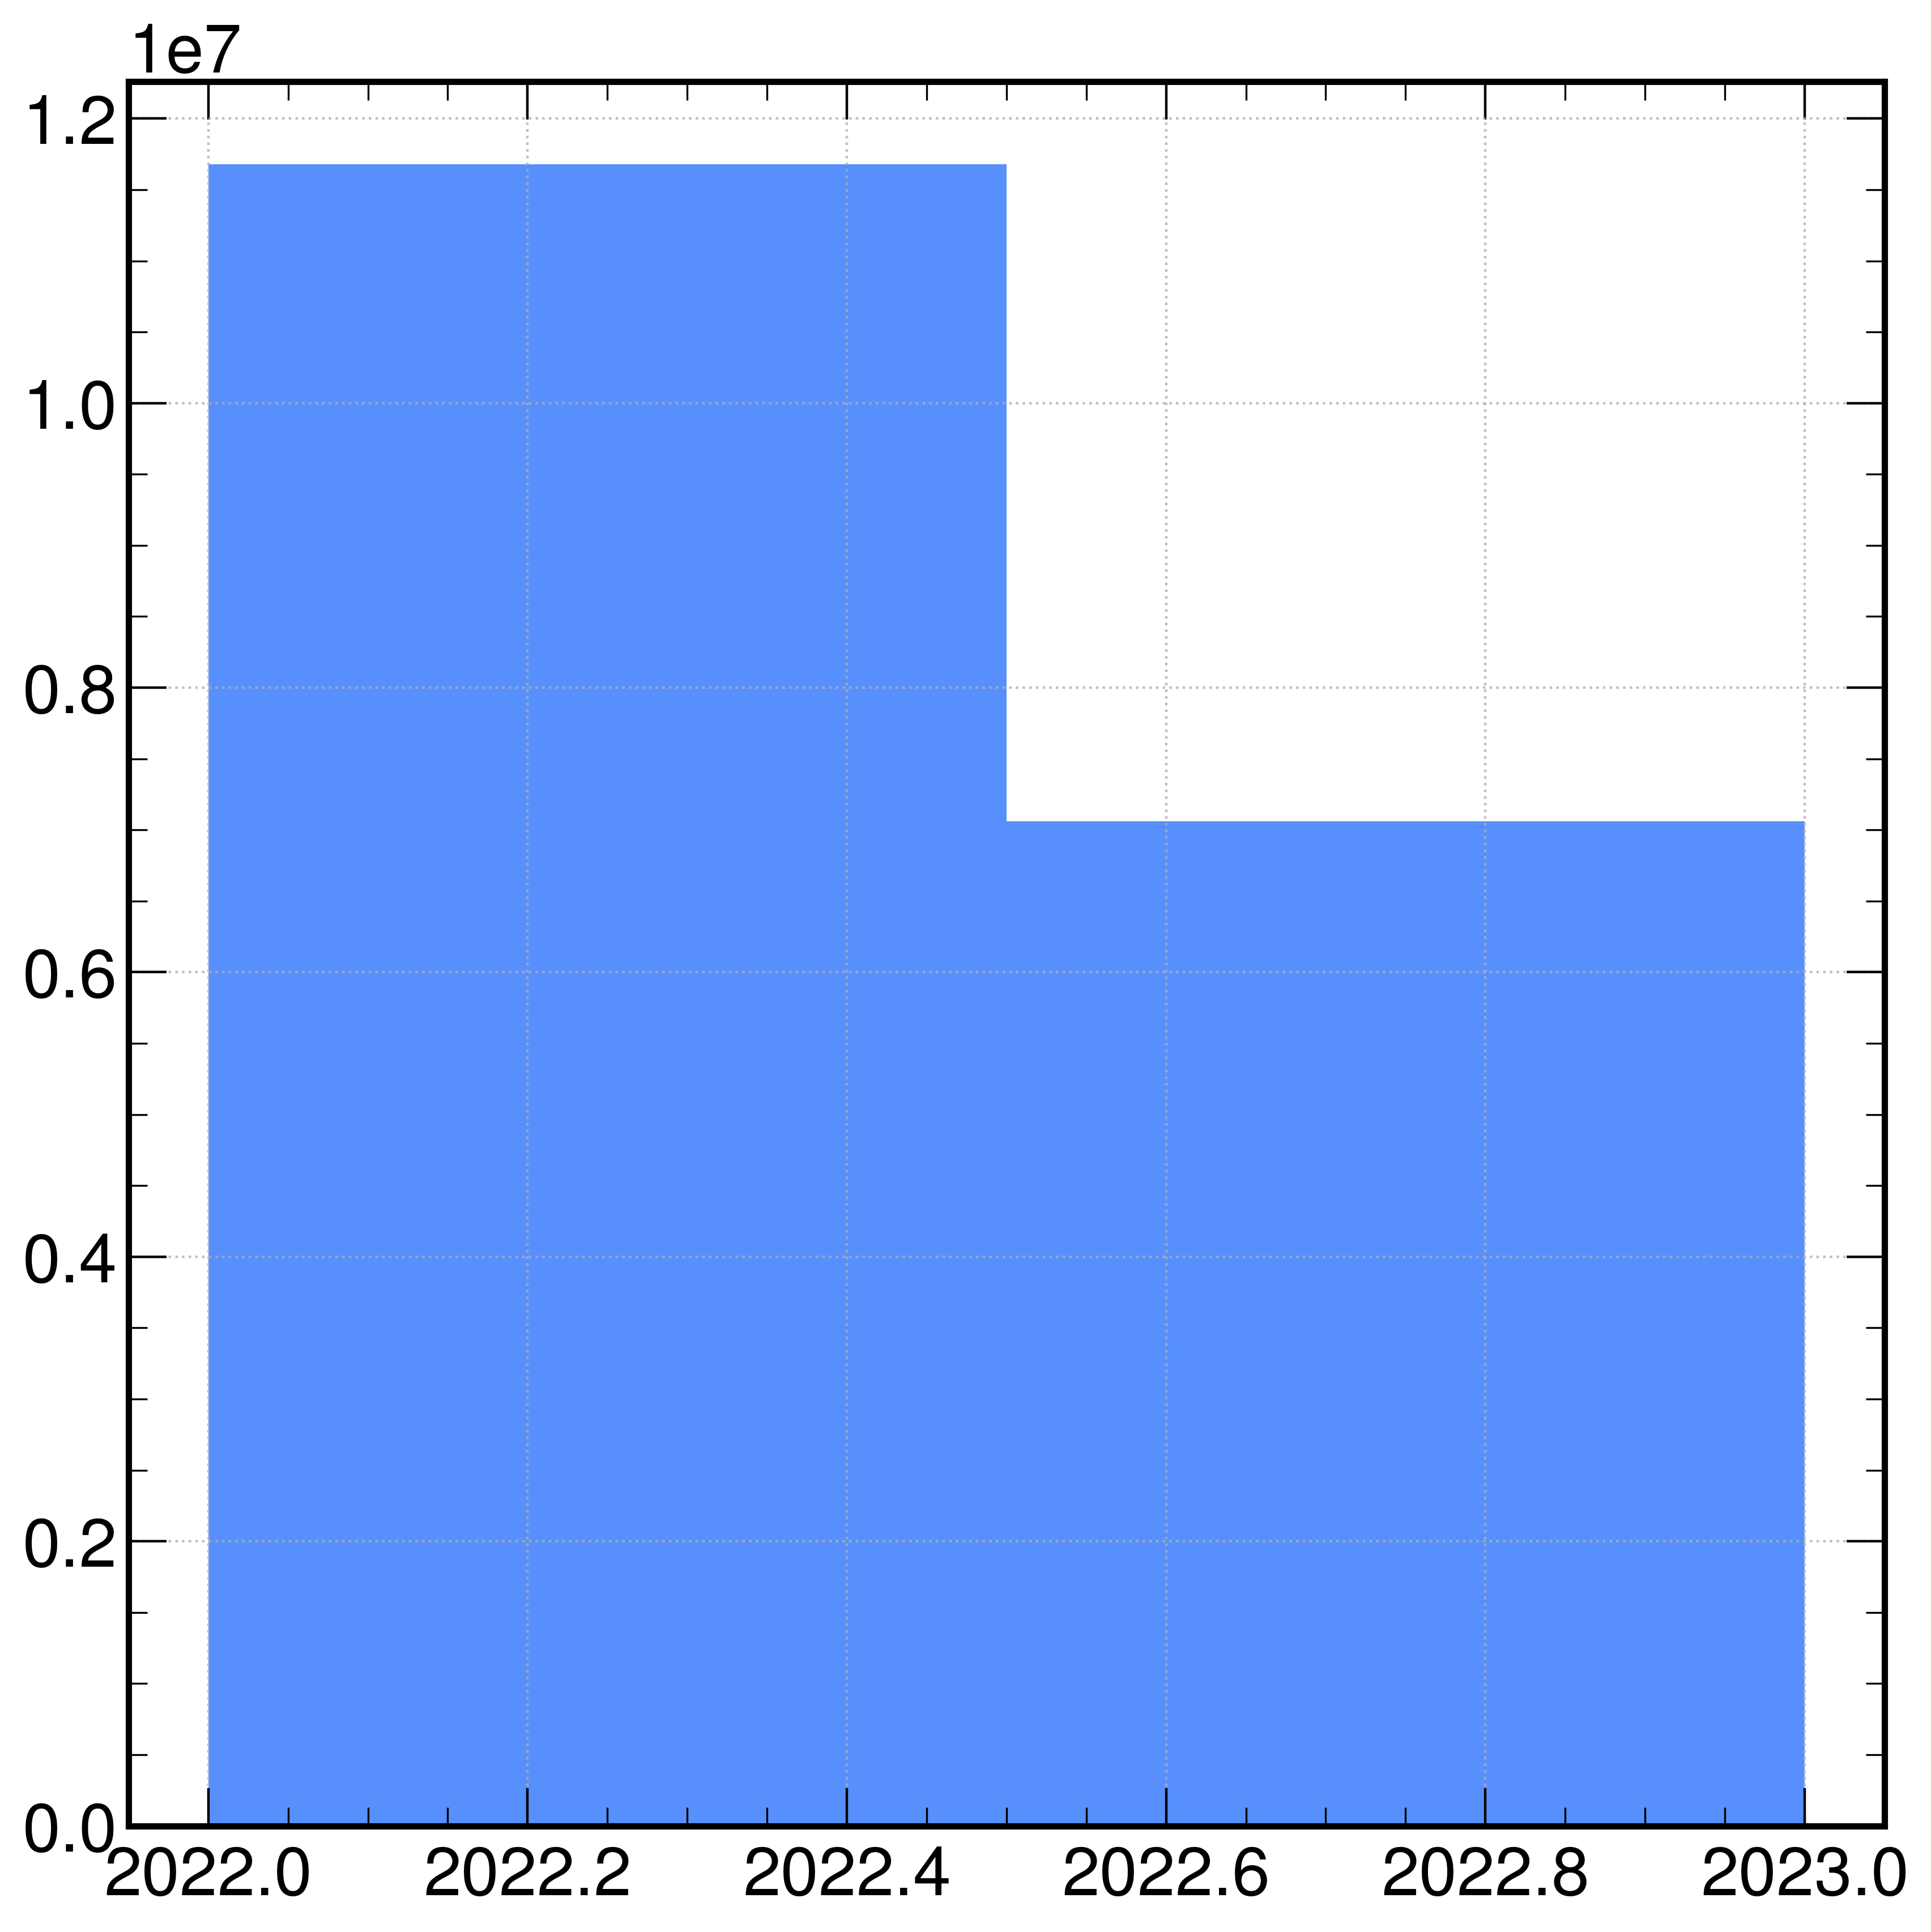

In [5]:
df.run_year.hist(bins=2)

In [6]:
output_dir = "outputs_dnn_v1"
os.makedirs(output_dir, exist_ok=True)
config_dict = {
    "output_dir": output_dir,
    "seed": seed,
}
print(f"Outputs will be written to {output_dir}")

Outputs will be written to outputs_dnn_v1


In [7]:
# # Get unique values
# pdgid_values = df['l1_pdgId'].unique() # should be same for l2
# charge_values = df['l1_charge'].unique() # should be same for l2

# # One-hot encode lepton_pdgid
# for val in pdgid_values:
#     df.loc[:, f'lepton_pdgid_{val}'] = (df['l1_pdgId'] == val).astype(int)
#     df.loc[:, f'lepton_pdgid_{val}'] = (df['l2_pdgId'] == val).astype(int)

# # One-hot encode lepton_charge
# for val in charge_values:
#     df.loc[:, f'lepton_charge_{val}'] = (df['l1_charge'] == val).astype(int)
#     df.loc[:, f'lepton_charge_{val}'] = (df['l2_charge'] == val).astype(int)

# # Drop original columns
# df = df.drop(columns=['l1_pdgId', 'l1_charge', 'l2_pdgId', 'l2_charge'])

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

exclude_cols = ["HH", "bkg", "weight", "event_no"]
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values.astype(np.float32)
y = df["HH"].values.astype(np.float32)
weights = df["weight"].values.astype(np.float32)

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=seed, stratify=y
)

X_train, X_valid, y_train, y_valid, weights_train, weights_valid = train_test_split(
    X_train, y_train, weights_train, test_size=0.2, random_state=seed, stratify=y_train
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

config_dict.update({"n_features": X_train.shape[1]})
print(
    f"Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}, features: {len(feature_cols)}"
)

Train: (11993077, 68), Valid: (2998270, 68), Test: (3747837, 68), features: 68


In [9]:
feature_cols

['l1_Px',
 'l1_Py',
 'l1_Pz',
 'l1_E',
 'l1_pdgId',
 'l1_charge',
 'leading_lepton_pt',
 'l2_Px',
 'l2_Py',
 'l2_Pz',
 'l2_E',
 'l2_pdgId',
 'l2_charge',
 'subleading_lepton_pt',
 'j1_Px',
 'j1_Py',
 'j1_Pz',
 'j1_E',
 'j1_btag',
 'j2_Px',
 'j2_Py',
 'j2_Pz',
 'j2_E',
 'j2_btag',
 'j3_Px',
 'j3_Py',
 'j3_Pz',
 'j3_E',
 'j3_btag',
 'j4_Px',
 'j4_Py',
 'j4_Pz',
 'j4_E',
 'j4_btag',
 'j8_Px',
 'j8_Py',
 'j8_Pz',
 'j8_E',
 'j8_btag',
 'j8_tau1',
 'j8_tau2',
 'j8_tau3',
 'j8_tau4',
 'j8_msoftdrop',
 'met_Px',
 'met_Py',
 'met_E',
 'HT',
 'met_LD',
 'dR_l1_l2',
 'dR_j1_j2',
 'dR_dilepton_dijet',
 'dR_dilepton_dibjet',
 'abs_dphi_met_dilepton',
 'abs_dphi_met_dibjet',
 'min_dR_l1_ak4jets',
 'min_dR_l2_ak4jets',
 'min_dR_lead_bjet_leptons',
 'min_dR_sublead_bjet_leptons',
 'min_dR_ak4jets',
 'min_abs_dphi_ak4jets',
 'di_bjet_mass',
 'di_lepton_mass',
 'di_lepton_met_mass',
 'di_lepton_dijet_met_mass',
 'VBF_tag',
 'boosted_tag',
 'run_year']

In [10]:
# 1. Calculate the correlation matrix
# Using the 'feature_cols' list defined in your notebook to select only input features
corr_matrix = df[feature_cols].corr()

# 2. Plot the heatmap
plt.figure(figsize=(24, 20))  # Large size to accommodate all 72 features

sns.heatmap(
    corr_matrix,
    annot=False,       # Turned off annotations as they would be unreadable with 72 features
    cmap='coolwarm',   # Diverging colormap (red for positive, blue for negative)
    center=0,          # Center the colormap at 0 correlation
    square=True,       # Force square cells
    linewidths=0.1,    # Thin lines between cells
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix of Input Features', fontsize=20)
plt.tight_layout()
plt.savefig(f"{output_dir}/correlation_matrix_inputs.png")
plt.show()

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


def make_tensors(X, y, w):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    w_t = torch.tensor(w, dtype=torch.float32)
    w_t = w_t / torch.clamp(w_t.mean(), min=1e-6)
    return X_t, y_t, w_t

Xtr_t, ytr_t, wtr_t = make_tensors(X_train, y_train, weights_train)
Xva_t, yva_t, wva_t = make_tensors(X_valid, y_valid, weights_valid)
Xte_t, yte_t, wte_t = make_tensors(X_test, y_test, weights_test)

batch_size = 2048
train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t, wtr_t), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(Xva_t, yva_t, wva_t), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(Xte_t, yte_t, wte_t), batch_size=batch_size, shuffle=False)

print(f"Batches — train: {len(train_loader)}, valid: {len(valid_loader)}, test: {len(test_loader)}")

Using device: cuda
Batches — train: 5856, valid: 1464, test: 1830


In [ ]:
from copy import deepcopy

hidden_sizes = [256, 128, 64]
dropout = 0.1
learning_rate = 1e-3
weight_decay = 1e-4
num_epochs = 40
patience = 5

config_dict.update(
    {
        "model": "MLP",
        "hidden_sizes": hidden_sizes,
        "dropout": dropout,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epochs": num_epochs,
        "patience": patience,
    }
)

class MLP(nn.Module):
    def __init__(self, in_features: int, hidden: list[int], dropout: float = 0.1):
        super().__init__()
        layers = []
        prev = in_features
        for h in hidden:
            layers.extend(
                [
                    nn.Linear(prev, h),
                    nn.BatchNorm1d(h),
                    nn.ReLU(),
                    nn.Dropout(dropout),
                ]
            )
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x).squeeze(-1)


model = MLP(config_dict["n_features"], hidden_sizes, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.BCEWithLogitsLoss(reduction="none")

def run_epoch(loader, train: bool = True):
    if train:
        model.train()
    else:
        model.eval()
    total_loss = 0.0
    all_logits, all_targets, all_weights = [], [], []
    for xb, yb, wb in loader:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss = (loss * wb).mean()
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
        total_loss += loss.item() * xb.size(0)
        all_logits.append(logits.detach().cpu())
        all_targets.append(yb.cpu())
        all_weights.append(wb.cpu())
    logits_cat = torch.sigmoid(torch.cat(all_logits)).numpy()
    targets_cat = torch.cat(all_targets).numpy()
    weights_cat = torch.cat(all_weights).numpy()
    avg_loss = total_loss / len(loader.dataset)
    auc = roc_auc_score(targets_cat, logits_cat, sample_weight=weights_cat)
    return avg_loss, auc, logits_cat, targets_cat, weights_cat

best_state = None
best_auc = -np.inf
patience_ctr = 0
train_losses, valid_losses, valid_aucs = [], [], []

start_time = time()
for epoch in range(1, num_epochs + 1):
    tr_loss, tr_auc, _, _, _ = run_epoch(train_loader, train=True)
    va_loss, va_auc, _, _, _ = run_epoch(valid_loader, train=False)
    train_losses.append(tr_loss)
    valid_losses.append(va_loss)
    valid_aucs.append(va_auc)

    if va_auc > best_auc:
        best_auc = va_auc
        best_state = deepcopy(model.state_dict())
        patience_ctr = 0
    else:
        patience_ctr += 1

    print(
        f"Epoch {epoch:02d} | train loss {tr_loss:.4f} | valid loss {va_loss:.4f} | valid AUC {va_auc:.4f}"
    )
    if patience_ctr >= patience:
        print("Early stopping triggered")
        break

train_time = time() - start_time
print(f"Training finished in {train_time:.1f} s | best valid AUC = {best_auc:.4f}")

if best_state is not None:
    model.load_state_dict(best_state)

torch.save(model.state_dict(), os.path.join(output_dir, "dnn_model.pt"))
with open(os.path.join(output_dir, "config.json"), "w") as f:
    json.dump(config_dict, f, indent=4)
print(f"Saved model and config to {output_dir}")

Epoch 01 | train loss 0.3617 | valid loss 0.3349 | valid AUC 0.9274
Epoch 02 | train loss 0.3338 | valid loss 0.3230 | valid AUC 0.9329
Epoch 03 | train loss 0.3256 | valid loss 0.3179 | valid AUC 0.9347
Epoch 04 | train loss 0.3198 | valid loss 0.3145 | valid AUC 0.9361
Epoch 05 | train loss 0.3166 | valid loss 0.3138 | valid AUC 0.9366
Epoch 06 | train loss 0.3133 | valid loss 0.3148 | valid AUC 0.9365
Epoch 07 | train loss 0.3108 | valid loss 0.3133 | valid AUC 0.9372
Epoch 08 | train loss 0.3082 | valid loss 0.3112 | valid AUC 0.9377
Epoch 09 | train loss 0.3063 | valid loss 0.3129 | valid AUC 0.9372


In [ ]:
print(f"Best validation AUC: {best_auc:.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    logits_list, targets_list, weights_list = [], [], []
    for xb, yb, wb in test_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        wb = wb.to(device)
        logits = model(xb)
        logits_list.append(logits.cpu())
        targets_list.append(yb.cpu())
        weights_list.append(wb.cpu())

y_pred = torch.sigmoid(torch.cat(logits_list)).numpy()
y_true = torch.cat(targets_list).numpy()
weights_true = torch.cat(weights_list).numpy()

test_auc = roc_auc_score(y_true, y_pred, sample_weight=weights_true)
print(f"DNN test ROC AUC: {test_auc:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_label = (y_pred > 0.5).astype(int)

cm = confusion_matrix(
    y_true, y_pred_label, sample_weight=weights_true, normalize="true"
)
display_labels = ["Background", "Signal"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="Blues", values_format=".2f")
disp.ax_.set_yticklabels(display_labels, rotation=90)

disp.ax_.text(
    0.0,
    1.05,
    "Private work (CMS simulation)",
    fontsize=20,
    fontproperties="Tex Gyre Heros:italic",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)
disp.ax_.text(
    0.8,
    1.05,
    "(13.6 TeV)",
    fontsize=20,
    fontproperties="Tex Gyre Heros",
    transform=disp.ax_.transAxes,
    verticalalignment="top",
)

cbar = disp.figure_.axes[-1]
cbar.set_position(
    [
        cbar.get_position().x0,
        disp.ax_.get_position().y0,
        cbar.get_position().width,
        disp.ax_.get_position().height,
    ]
)
plt.savefig(f"{output_dir}/dnn_confusion_matrix.png")
plt.show()
print(f"Confusion matrix saved to {output_dir}/dnn_confusion_matrix.png")

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train loss", color="navy", marker="o", markersize=4, alpha=0.6)
plt.plot(valid_losses, label="Validation loss", color="red", marker="s", markersize=4, alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/dnn_loss_curve.png")
plt.show()

plt.figure()
plt.plot(valid_aucs, label="Validation AUC", color="green", marker="^", markersize=4, alpha=0.6)
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.ylim(0.5, 1.0)
plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/dnn_auc_curve.png")
plt.show()

In [ ]:
plt.figure()

density = False
y_label = "N events"
if density:
    y_label = "Density"

plt.hist(
    y_pred[y_true == 1],
    weights=weights_true[y_true == 1],
    bins=50,
    histtype="step",
    color="navy",
    label="Signal",
    density=density,
)
plt.hist(
    y_pred[y_true == 0],
    weights=weights_true[y_true == 0],
    bins=50,
    histtype="step",
    color="red",
    label="Background",
    density=density,
)
plt.xlabel("DNN Output Score")
plt.ylabel(y_label)
plt.legend()

plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.gca().set_yscale("log")
plt.savefig(f"{output_dir}/dnn_score_dist.png")
plt.show()
print(f"Score distribution saved to {output_dir}/dnn_score_dist.png")

In [ ]:
roc_auc = roc_auc_score(y_true, y_pred, sample_weight=weights_true)
print(f"DNN ROC AUC: {roc_auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_pred, sample_weight=weights_true)
plt.figure()
plt.plot(fpr, tpr, label=f"DNN ROC (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(
    "Private work (CMS simulation)",
    fontsize=24,
    loc="left",
    pad=10,
    fontproperties="Tex Gyre Heros:italic",
)
plt.title(
    "(13.6 TeV)", fontsize=24, loc="right", pad=8, fontproperties="Tex Gyre Heros"
)
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/dnn_roc_curve.png")
plt.show()
print(f"ROC curve saved to {output_dir}/dnn_roc_curve.png")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

acc = accuracy_score(y_true, y_pred_label, sample_weight=weights_true)
prec = precision_score(y_true, y_pred_label, sample_weight=weights_true)
rec = recall_score(y_true, y_pred_label, sample_weight=weights_true)
print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f}")